In [2]:
%autoreload 2

In [3]:
from argparse import Namespace
from collections import defaultdict
import copy
import difflib
import gzip
import itertools
import os
import pickle
import sys
import typing

from IPython.display import display, Markdown, HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
import tatsu
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm.notebook as tqdm


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.ast_counter_sampler import *
from src.ast_utils import cached_load_and_parse_games_from_file, load_games_from_file, _extract_game_id
from src import ast_printer

In [4]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..')
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))


In [5]:
fitness_df = utils.load_fitness_data()
fitness_df = fitness_df.assign(real=fitness_df.real.astype('int'))
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples.pddl']


,Index,src_file,game_name,domain_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,no_adjacent_once,starts_and_ends_once,...,node_count_terminal_2,node_count_terminal_3,node_count_terminal_4,node_count_scoring_0,node_count_scoring_1,node_count_scoring_2,node_count_scoring_3,node_count_scoring_4,real,original_game_name
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,1.0,1.0,1.0,1.00,1.0,0.5,...,1,0,0,1,0,0,0,0,1,6172feb1665491d1efbce164-0
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,1.0,1.0,1.0,1.00,1.0,1.0,...,1,0,0,0,0,0,1,0,1,5f77754ba932fb2c4ba181d8-2
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,1.0,1.0,1.0,0.00,1.0,0.0,...,0,0,0,0,1,0,0,0,1,614b603d4da88384282967a7-3
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,1.0,1.0,1.0,0.00,1.0,1.0,...,0,0,0,1,0,0,0,0,1,5bc79f652885710001a0e82a-5
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,1.0,1.0,1.0,0.25,1.0,1.0,...,0,0,0,0,0,1,0,0,1,614dec67f6eb129c3a77defd-6


In [6]:
def create_filtered_df(df: pd.DataFrame, 
    synthetic_data_src_files: typing.Sequence[str] = ('interactive-beta.pddl', 'ast-real-regrowth-samples.pddl'),
    ) -> pd.DataFrame:
    syntethic_df = fitness_df[fitness_df.src_file.isin(synthetic_data_src_files)].reset_index(drop=True)
    syntethic_df.loc[syntethic_df.src_file == synthetic_data_src_files[0], 'real'] = 1
    return syntethic_df

filtered_fitness_df = create_filtered_df(fitness_df)

In [7]:
filtered_fitness_df.head()

,Index,src_file,game_name,domain_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,no_adjacent_once,starts_and_ends_once,...,node_count_terminal_2,node_count_terminal_3,node_count_terminal_4,node_count_scoring_0,node_count_scoring_1,node_count_scoring_2,node_count_scoring_3,node_count_scoring_4,real,original_game_name
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,1.0,1.0,1.0,1.00,1.0,0.5,...,1,0,0,1,0,0,0,0,1,6172feb1665491d1efbce164-0
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,1.0,1.0,1.0,1.00,1.0,1.0,...,1,0,0,0,0,0,1,0,1,5f77754ba932fb2c4ba181d8-2
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,1.0,1.0,1.0,0.00,1.0,0.0,...,0,0,0,0,1,0,0,0,1,614b603d4da88384282967a7-3
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,1.0,1.0,1.0,0.00,1.0,1.0,...,0,0,0,1,0,0,0,0,1,5bc79f652885710001a0e82a-5
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,1.0,1.0,1.0,0.25,1.0,1.0,...,0,0,0,0,0,1,0,0,1,614dec67f6eb129c3a77defd-6


In [8]:
fake_games = filtered_fitness_df[filtered_fitness_df.src_file == 'ast-real-regrowth-samples.pddl'].reset_index()
broadcasted_original = filtered_fitness_df.loc[[filtered_fitness_df.index[(filtered_fitness_df.game_name == original_name)][0] for original_name in fake_games.original_game_name], :].reset_index()

original_regrown_diffs = (broadcasted_original.drop(NON_FEATURE_COLUMNS, axis=1) - fake_games.drop(NON_FEATURE_COLUMNS, axis=1))

unchanged_games_prop = (original_regrown_diffs.drop('index', axis=1) == 0).all(axis=1).sum() / len(original_regrown_diffs)
print(f'In {unchanged_games_prop * 100:.2f}% of the games, the regrown game was identical to the original game.')

In 4.48% of the games, the regrown game was identical to the original game.


In [9]:
never_change = (original_regrown_diffs.drop('index', axis=1) == 0).all(axis=0)
for x in never_change.index[never_change]:
    print(x)

correct_predicate_function_arity
section_without_pref_count_terminal
section_without_pref_count_scoring
arg_types_adjacent_any_object_blocks
arg_types_adjacent_any_object_building
arg_types_adjacent_any_object_ramps
arg_types_adjacent_any_object_room_features
arg_types_adjacent_any_object_small_objects
arg_types_adjacent_balls_any_object
arg_types_adjacent_blocks_ramps
arg_types_adjacent_colors_any_object
arg_types_adjacent_colors_blocks
arg_types_adjacent_colors_large_objects
arg_types_adjacent_colors_ramps
arg_types_adjacent_colors_receptacles
arg_types_adjacent_colors_room_features
arg_types_adjacent_colors_small_objects
arg_types_adjacent_furniture_colors
arg_types_adjacent_furniture_small_objects
arg_types_adjacent_building_agent
arg_types_adjacent_building_any_object
arg_types_adjacent_building_balls
arg_types_adjacent_building_colors
arg_types_adjacent_building_large_objects
arg_types_adjacent_building_ramps
arg_types_adjacent_building_small_objects
arg_types_adjacent_large_obje

In [10]:
sum(never_change)

156

In [11]:
original_df = filtered_fitness_df[filtered_fitness_df.src_file == 'interactive-beta.pddl'].reset_index(drop=True)
arr = np.array(original_df.all_variables_used) 
ind = np.where(arr != 1)[0]
print(ind)
original_df.iloc[ind, :]

[]


,Index,src_file,game_name,domain_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,no_adjacent_once,starts_and_ends_once,...,node_count_terminal_2,node_count_terminal_3,node_count_terminal_4,node_count_scoring_0,node_count_scoring_1,node_count_scoring_2,node_count_scoring_3,node_count_scoring_4,real,original_game_name


# Synthetic model-fitting experiment approach
We have a large dataset now, I can try to cross-validate over some of the choices I might make:
* Loss function
* Parameters of each loss function (margin, etc.)
* Batch size
* Number of negative examples sampled per iteration
* Regularization strength?
* ...?



In [12]:
test_param_grid = [
    {
        'fitness__loss_function': [utils.fitness_hinge_loss], # [utils.fitness_hinge_loss_with_cross_example],
        'fitness__weight_decay': [0.0, 0.25, 1, 2],  
        'fitness__margin': [1, 2, 4, 8],
        # 'fitness__beta': [0.25, 1, 2, 4],
        'fitness__lr':  [1e-1, 3e-2, 1e-2, 3e-3],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [4, 8, 16, 32, 64],
        'fitness__batch_size': [2, 4, 8, 16],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
    },
    # {
    # #     'fitness__loss_function': [utils.fitness_log_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # # },
    # # {
    # #     'fitness__loss_function': [utils.fitness_square_square_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__margin': [1, 2, 4],
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # },   
]

all_feature_columns = [c for c in filtered_fitness_df.columns if c not in NON_FEATURE_COLUMNS]
model_kwargs = dict(output_activation=nn.Identity())
train_kwargs = dict(negative_score_reduction='none')
cv_kwargs = dict(refit='overall_ecdf')
scoring = utils.build_multiple_scoring_function(
    [utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank],
    ['overall_ecdf', 'single_game_rank'],
)

cv, (train_tensor, test_tensor), test_results = utils.model_fitting_experiment(fitness_df, test_param_grid,
    feature_columns=all_feature_columns, scoring_function=scoring, verbose=1, 
    model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs)


print(test_results)


Fitting 5 folds for each of 1280 candidates, totalling 6400 fits
{'ecdf': -0.2875, 'game_rank': 0.883593738079071}


### Test results:

{'ecdf': -0.2875, 'game_rank': 0.883593738079071}

### CV results by overall ECDF:

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
23,2,4,<function fitness_hinge_loss at 0x15d422950>,0.030,2,835,2.0,-0.281537,0.022380,1,0.875768,0.017126,187
842,8,32,<function fitness_hinge_loss at 0x15d422950>,0.100,4,835,1.0,-0.285058,0.014553,2,0.876224,0.019503,169
650,8,4,<function fitness_hinge_loss at 0x15d422950>,0.100,4,835,1.0,-0.286557,0.036975,3,0.878958,0.022821,74
519,4,32,<function fitness_hinge_loss at 0x15d422950>,0.100,2,835,2.0,-0.287402,0.031263,4,0.879245,0.024634,71
19,2,4,<function fitness_hinge_loss at 0x15d422950>,0.030,1,835,2.0,-0.287886,0.028955,5,0.869687,0.026716,539
106,2,8,<function fitness_hinge_loss at 0x15d422950>,0.010,4,835,1.0,-0.288200,0.026962,6,0.876120,0.027118,172
27,2,4,<function fitness_hinge_loss at 0x15d422950>,0.030,4,835,2.0,-0.288593,0.017182,7,0.871042,0.013151,441
727,8,8,<function fitness_hinge_loss at 0x15d422950>,0.030,2,835,2.0,-0.290006,0.010247,8,0.877813,0.017958,108
110,2,8,<function fitness_hinge_loss at 0x15d422950>,0.010,8,835,1.0,-0.290021,0.031152,9,0.877656,0.025425,113
308,2,64,<function fitness_hinge_loss at 0x15d422950>,0.003,2,835,0.0,-0.290052,0.022463,10,0.880456,0.019443,51


### CV results by mean single game rank:

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
264,2,64,<function fitness_hinge_loss at 0x15d422950>,0.10,4,835,0.0,-0.308284,0.033115,587,0.889896,0.013203,1
268,2,64,<function fitness_hinge_loss at 0x15d422950>,0.10,8,835,0.0,-0.305536,0.036424,408,0.889180,0.016288,2
600,4,64,<function fitness_hinge_loss at 0x15d422950>,0.03,4,835,0.0,-0.299498,0.026541,140,0.888958,0.018105,3
584,4,64,<function fitness_hinge_loss at 0x15d422950>,0.10,4,835,0.0,-0.298211,0.032003,105,0.888932,0.017643,4
284,2,64,<function fitness_hinge_loss at 0x15d422950>,0.03,8,835,0.0,-0.298208,0.025455,104,0.887682,0.015759,5
260,2,64,<function fitness_hinge_loss at 0x15d422950>,0.10,2,835,0.0,-0.305484,0.035014,403,0.887630,0.010279,6
280,2,64,<function fitness_hinge_loss at 0x15d422950>,0.03,4,835,0.0,-0.303382,0.028510,306,0.887591,0.015791,7
204,2,32,<function fitness_hinge_loss at 0x15d422950>,0.10,8,835,0.0,-0.302909,0.026834,271,0.887344,0.018931,8
524,4,32,<function fitness_hinge_loss at 0x15d422950>,0.10,8,835,0.0,-0.302294,0.027038,244,0.887161,0.017782,9
300,2,64,<function fitness_hinge_loss at 0x15d422950>,0.01,8,835,0.0,-0.293942,0.023001,26,0.887161,0.018154,9


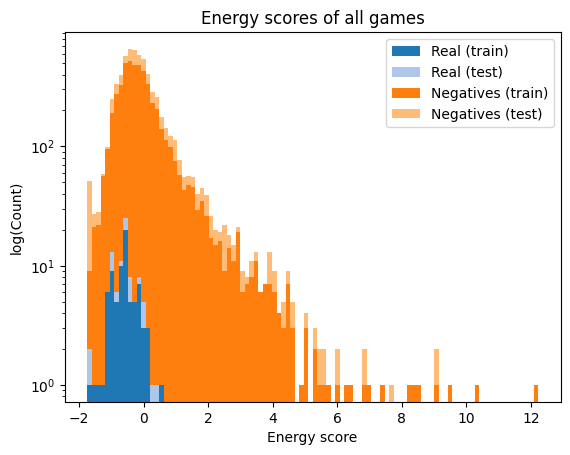

0.0023442875 0.022911713 4.6121598e-10


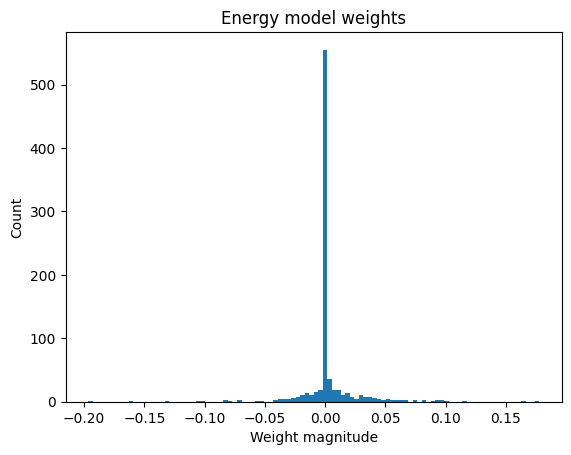

In [14]:
utils.visualize_cv_outputs(cv, train_tensor, test_tensor, test_results)  #, histogram_title_note='with `real` flag')

In [17]:
filtered_df = create_filtered_df(fitness_df)
feature_columns = [c for c in filtered_df.columns if c not in NON_FEATURE_COLUMNS]
full_tensor = utils.df_to_tensor(filtered_df, feature_columns)

In [ ]:
cv.best_estimator_.fit(full_tensor)

SAVE_MODEL = False
if SAVE_MODEL:
    output_path = '../models/cv_fitness_model_2022_01_17.pkl.gz'
    original_output_path = output_path[:]
    i = 0
    while os.path.exists(output_path):
        output_path = original_output_path + f'_{i}'
        i += 1

    with gzip.open(output_path, 'wb') as f:
        pickle.dump(cv.best_estimator_, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# DEFAULT_FITNESS_FUNCTION_PATH = '../models/cv_fitness_model_2022_12_23.pkl.gz'
# with gzip.open(DEFAULT_FITNESS_FUNCTION_PATH, 'rb') as f:
#     cv_fitness_model = pickle.load(f)

cv_fitness_model = cv.best_estimator_

In [ ]:
cv.best_estimator_.fit(train_tensor)

In [15]:
weights = cv.best_estimator_.named_steps['fitness'].model.fc1.weight.data.detach().numpy().squeeze()  # type: ignore
feature_columns = [c for c in fitness_df.columns if c not in NON_FEATURE_COLUMNS]
n_top = 10
sorted_indices = np.argsort(weights)
top_weight_indices = sorted_indices[-n_top:]
bottom_weight_indices = sorted_indices[:n_top]

top_features = [feature_columns[i] for i in top_weight_indices][::-1]
bottom_features = [feature_columns[i] for i in bottom_weight_indices]

print('Features with strongest negative weights')
for i, f in enumerate(bottom_features):
    print(f'{i+1}. {f} ({weights[bottom_weight_indices[i]]:.3f})')

print('Features with strongest positive weights')
for i, f in enumerate(top_features):
    print(f'{i+1}. {f} ({weights[top_weight_indices[i]]:.3f})')



Features with strongest negative weights
1. pref_forall_used (-0.197)
2. all_variables_used (-0.161)
3. pref_forall_correct_types (-0.132)
4. pref_forall_correct_arity (-0.103)
5. variable_not_repeated (-0.100)
6. all_variables_defined (-0.081)
7. arg_types_in_receptacles_balls (-0.081)
8. all_preferences_used (-0.078)
9. no_nested_logicals (-0.072)
10. compositionality_structure_1 (-0.071)
Features with strongest positive weights
1. arg_types_on_agent_colors (0.082)
2. arg_types_in_colors_ramps (0.091)
3. arg_types_touch_blocks_receptacles (0.092)
4. arg_types_on_blocks_colors (0.092)
5. arg_types_in_motion_receptacles (0.096)
6. arg_types_in_ramps_room_features (0.097)
7. arg_types_adjacent_ramps_ramps (0.100)
8. arg_types_in_motion_agent (0.115)
9. node_count_terminal_4 (0.163)
10. arg_types_adjacent_blocks_agent (0.177)


In [16]:
train_negative_scores = cv.best_estimator_.transform(train_tensor[:, 1:, :]).detach().squeeze()  # type: ignore
train_positive_scores = cv.best_estimator_.transform(train_tensor[:, 0, :]).detach().squeeze()  # type: ignore
score_diffs = train_positive_scores.unsqueeze(-1) - train_negative_scores
torch.topk(score_diffs.ravel(), k=20, largest=True)

torch.return_types.topk(
values=tensor([0.6171, 0.6149, 0.5331, 0.2999, 0.2939, 0.2777, 0.2590, 0.2551, 0.2515,
        0.2391, 0.2349, 0.2340, 0.2197, 0.2197, 0.2195, 0.2195, 0.2095, 0.2044,
        0.1899, 0.1899]),
indices=tensor([1463, 1858, 1919, 2755, 1890, 3012, 3621, 4618, 4630, 2161, 2792, 3601,
        1868, 1879, 1860, 1872, 3987, 2797, 2171, 2397]))

In [30]:
utils.evaluate_energy_contributions(cv, train_tensor, 3621, feature_columns, full_tensor, real_game_texts, regrown_game_texts, top_k=5)

Energy of real game: -0.207 | Energy of index: -0.466 | Difference: -0.259


### Top features pushing the energy up relative to real game [(feature value => scaled feature value) X (weight)]

arg_types_in_motion_balls: 0.060 = (5.000 => 1.498 | 7.000 => 2.544) * -0.057

arg_types_agent_holds_balls: 0.041 = (2.000 => -0.118 | 4.000 => 0.924) * -0.039

### Top features pushing the energy down relative to real game [(feature value => scaled feature value) X (weight)]

arg_types_touch_balls_balls: -0.204 = (0.000 => -0.149 | 1.000 => 6.478) * 0.031

arg_types_in_motion_any_object: -0.070 = (2.000 => 2.825 | 0.000 => -0.232) * -0.023

arg_types_touch_any_object_balls: -0.045 = (1.000 => 4.739 | 0.000 => -0.115) * -0.009

arg_types_agent_holds_any_object: -0.041 = (2.000 => 3.479 | 0.000 => -0.212) * -0.011

### Game Diffs

Original game index: 67 | Negative game row: 56 | Negative game col: 37


n,1,(define (game 5eeb326764eb142830aa5cfb-78) (:domain medium-o,n,1,(define (game 5eeb326764eb142830aa5cfb-78-37) (:domain mediu
,>,bjects-room-v1),,>,m-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?t - teddy_bear),,4,(exists (?t - teddy_bear)
,5,(game-optional,,5,(game-optional
,6,(and,,6,(and
,7,(adjacent_side bed front_left_corner ?t),,7,(adjacent_side bed front_left_corner ?t)
,8,(object_orientation ?t upright),,8,(object_orientation ?t upright)
,9,),,9,)
,10,),,10,)


### Features Diffs

arg_types_agent_holds_balls: -2.000 => -1.042
arg_types_in_motion_balls: -2.000 => -1.046
arg_types_touch_balls_balls: -1.000 => -6.627
arg_types_touch_any_object_balls: 1.000 => 4.854
arg_types_agent_holds_any_object: 2.000 => 3.691
arg_types_in_motion_any_object: 2.000 => 3.057


## Alternative experiments

In [ ]:
test_param_grid = [
    {
        'fitness__loss_function': [utils.fitness_softmin_hybrid_loss], # [utils.fitness_hinge_loss_with_cross_example],
        'fitness__weight_decay': [0.0, 0.25, 1, 2],  
        'fitness__margin': [1, 2, 4, 8],
        'fitness__beta': [0.25, 1, 2, 4],
        'fitness__lr':  [1e-1, 3e-2, 1e-2, 3e-3],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [4, 8, 16, 32, 64],
        'fitness__batch_size': [2, 4, 8, 16],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
    },
    # {
    # #     'fitness__loss_function': [utils.fitness_log_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # # },
    # # {
    # #     'fitness__loss_function': [utils.fitness_square_square_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__margin': [1, 2, 4],
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # },
    
]

all_feature_columns = [c for c in filtered_fitness_df.columns if c not in NON_FEATURE_COLUMNS]
model_kwargs = dict(output_activation=nn.Identity())
train_kwargs = dict()
cv_kwargs = dict(refit='single_game_rank')
scoring = utils.build_multiple_scoring_function(
    [utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank],
    ['overall_ecdf', 'single_game_rank'],
)

cv, (train_tensor, test_tensor), test_results = utils.model_fitting_experiment(fitness_df, test_param_grid,
    scoring_function=scoring, verbose=1, 
    model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs)

print(test_results)


utils.visualize_cv_outputs(cv, train_tensor, test_tensor, test_results)

## Trying the old hinge loss, but with no negative averaging

In [ ]:
test_param_grid = [
    # {
    #     'fitness__loss_function': [utils.fitness_hinge_loss], # [utils.fitness_hinge_loss_with_cross_example],
    #     'fitness__weight_decay': [0.0, 0.25, 1, 2],  
    #     'fitness__margin': [1, 2, 4, 8],
    #     # 'fitness__beta': [0.25, 1, 2, 4],
    #     'fitness__lr':  [1e-1, 3e-2, 1e-2, 3e-3],  # [1e-1, 3e-2, 1e-2, 3e-3],
    #     'fitness__k': [4, 8, 16, 32, 64],
    #     'fitness__batch_size': [4, 8, 16, 32],  # [1, 4, 8, 16],
    #     # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
    # },
    {
        'fitness__loss_function': [utils.fitness_hinge_loss], # [utils.fitness_hinge_loss_with_cross_example],
        'fitness__weight_decay': [0.0, ],  
        'fitness__margin': [1, 2,],
        # 'fitness__beta': [0.25, 1, 2, 4],
        'fitness__lr':  [1e-1, 3e-2,],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [32, 64],
        'fitness__batch_size': [8, 16],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
    },
]

all_feature_columns = [c for c in filtered_fitness_df.columns if c not in NON_FEATURE_COLUMNS]
model_kwargs = dict(output_activation=nn.Identity())
train_kwargs = dict(negative_score_reduction='none')
cv_kwargs = dict(refit='single_game_rank')
scoring = utils.build_multiple_scoring_function(
    [utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank],
    ['overall_ecdf', 'single_game_rank'],
)

cv, (train_tensor, test_tensor), test_results = utils.model_fitting_experiment(fitness_df, test_param_grid,
    scoring_function=scoring, verbose=1, 
    model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs)

print(test_results)

utils.visualize_cv_outputs(cv, train_tensor, test_tensor, test_results)